In [1]:
import tensorflow as tf

In [2]:
import IPython.display as display

from PIL import Image

import numpy as np

import matplotlib.pyplot as plt

import pathlib

import os # testing optimization

In [3]:
train_data_directory      = pathlib.Path(r"/home/jupyter/action-recognition/Frames/Train")
validation_data_directory = pathlib.Path(r"/home/jupyter/action-recognition/Frames/Test")

In [4]:
image_count = len(list(train_data_directory.glob('*/*.jpg')))
image_count

5660

In [5]:
test_image_count = len(list(validation_data_directory.glob('*/*.jpg')))
test_image_count

2291

In [6]:
#!!!!!!!!!!!!!!!!!! testing optimization !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

trainFramePaths = tf.data.Dataset.list_files(str(train_data_directory/'*/*'))
validationFramePaths = tf.data.Dataset.list_files(str(validation_data_directory/'*/*'))
print(trainFramePaths, type(trainFramePaths), "\n")
for f in trainFramePaths.take(6):
    print(f.numpy())

<ShuffleDataset shapes: (), types: tf.string> <class 'tensorflow.python.data.ops.dataset_ops.ShuffleDataset'> 

b'/home/jupyter/action-recognition/Frames/Train/ApplyEyeMakeup/v_ApplyEyeMakeup_g24_c01_0012.jpg'
b'/home/jupyter/action-recognition/Frames/Train/ApplyLipstick/v_ApplyLipstick_g25_c02_0009.jpg'
b'/home/jupyter/action-recognition/Frames/Train/ApplyLipstick/v_ApplyLipstick_g08_c04_0008.jpg'
b'/home/jupyter/action-recognition/Frames/Train/Archery/v_Archery_g11_c01_0009.jpg'
b'/home/jupyter/action-recognition/Frames/Train/ApplyEyeMakeup/v_ApplyEyeMakeup_g25_c07_0009.jpg'
b'/home/jupyter/action-recognition/Frames/Train/Archery/v_Archery_g18_c07_0018.jpg'


In [7]:
CLASS_NAMES = np.array([item.name for item in train_data_directory.glob('*')])
CLASS_NAMES

array(['Archery', 'ApplyLipstick', 'ApplyEyeMakeup'], dtype='<U14')

In [8]:
def get_label(file_path):
  # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

In [9]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [224, 224])

In [10]:
def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
labeled_train_ds = trainFramePaths.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_validation_ds = validationFramePaths.map(process_path, num_parallel_calls=AUTOTUNE)
print(labeled_train_ds)
print(labeled_validation_ds)

<ParallelMapDataset shapes: ((224, 224, 3), (3,)), types: (tf.float32, tf.bool)>
<ParallelMapDataset shapes: ((224, 224, 3), (3,)), types: (tf.float32, tf.bool)>


In [14]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

NameError: name 'labeled_ds' is not defined

In [15]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(32)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [16]:
train_ds = prepare_for_training(labeled_train_ds)
validation_ds = prepare_for_training(labeled_validation_ds)
image_batch_t, label_batch_t = next(iter(train_ds))
image_batch_v, label_batch_v = next(iter(validation_ds))

In [17]:
print(type(train_ds))
print(type(validation_ds))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [18]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

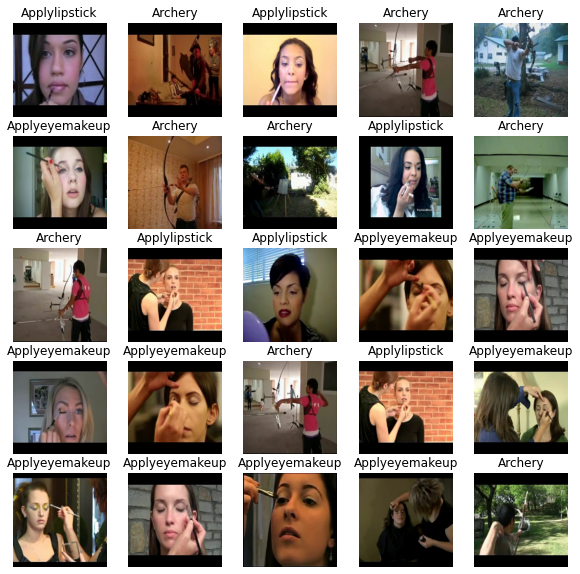

In [19]:
show_batch(image_batch_t.numpy(), label_batch_t.numpy())

#!!!!!!!!!!!!!!!!!! testing optimization !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

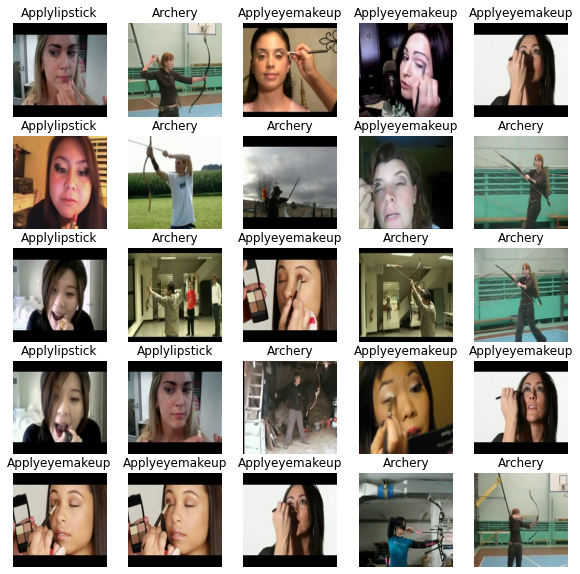

In [20]:
show_batch(image_batch_v.numpy(), label_batch_v.numpy())

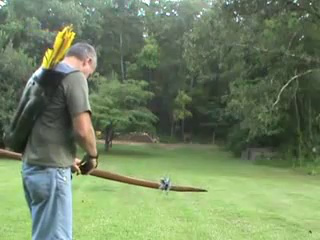

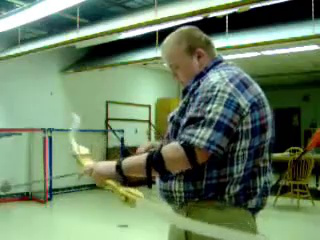

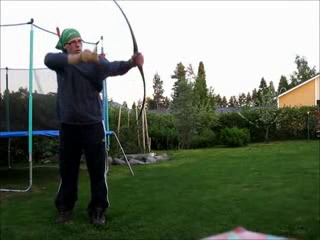

In [21]:
archery = list(train_data_directory.glob('Archery/*'))

for image_path in archery[:3]:
    display.display(Image.open(str(image_path)))

In [22]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [23]:
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [24]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [25]:
train_data_gen = image_generator.flow_from_directory(directory=str(train_data_directory),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 5660 images belonging to 3 classes.


In [26]:
validation_data_gen = image_generator.flow_from_directory(directory=str(validation_data_directory),
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                          classes = list(CLASS_NAMES))

Found 2291 images belonging to 3 classes.


In [27]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

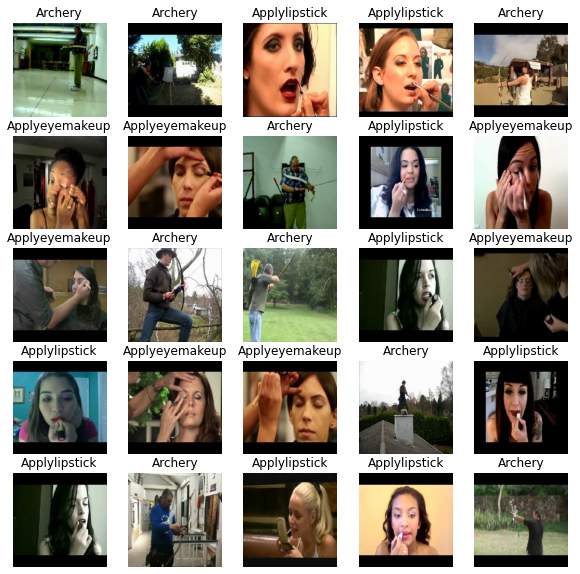

In [28]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [29]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [30]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [31]:
base_model.trainable = False

In [32]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [33]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [34]:
prediction_layer = tf.keras.layers.Dense(3)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [35]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [36]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [38]:
len(model.trainable_variables)

2

In [ ]:
loss0,accuracy0 = model.evaluate(validation_data_gen)

  ...
    to  
  ['...']
35/72 [=============>................] - ETA: 1:22 - loss: 1.2307 - accuracy: 0.3929

In [ ]:
epochs = 3
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=validation_data_gen
)

In [ ]:
epochs = 3
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
validation_steps= np.ceil(test_image_count/BATCH_SIZE)
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=validation_steps
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))